### 2차 프로그래밍 과제
#### 기존 수업 회귀 코드 참고 수정 및 Cursor 활용
--------
### 학생 성적 예측 회귀 분석 프로젝트 개요

#### **프로젝트 목적**
학생들의 다양한 요인(공부 시간, 출석률, 부모 참여도 등)을 분석하여 시험 성적을 예측하는 회귀 분석 프로젝트입니다.

#### **데이터 소개**
- **데이터셋**: `StudentPerformanceFactors.csv`
- **데이터 크기**: 6,607개 샘플, 20개 특성
- **타겟 변수**: `Exam_Score` 

### **특성 (Feature)**
Hours_Studied 공부 시간
Attendance 출석률
Gender 성별
Previous_Scores 이전 성적
Motivation_Level 동기 수준
Tutoring_Sessions 과외 횟수
Extracurricular_Activities 과외 활동 참여 여부
Parental_Involvement 부모 참여도
Access_to_Resources 자원 접근성
Internet_Access 인터넷 접근 여부
Family_Income 가족 소득
Teacher_Quality 교사 품질
School_Type 학교 유형 (공립/사립)
Sleep_Hours 수면 시간
Physical_Activity 신체 활동
Learning_Disabilities 학습 장애 여부
Peer_Influence 동료 영향
Parental_Education_Level 부모 교육 수준
Distance_from_Home 집에서의 거리
Exam_Score 시험 성적 (예측 대상) - 타겟 변수


### **사용된 모델 알고리즘**

#### 1. **Linear Regression (다중 선형 회귀)**
#### 2. **RidgeCV (릿지 회귀)**
#### 3. **LassoCV (라쏘 회귀)**
#### 4. **Polynomial Regression (다항 회귀)**
#### 5. **Polynomial + RidgeCV**

### **회귀 성능 결과**

| 모델 | R² Score | MSE | MAE | RMSE |
|------|----------|-----|-----|------|
| **LassoCV** | **0.6405** | 5.8532 | 0.5449 | 2.4193 |
| **RidgeCV** | **0.6405** | 5.8544 | 0.5437 | 2.4196 |
| **Linear Regression** | **0.6404** | 5.8554 | 0.5436 | 2.4198 |
| **Poly+RidgeCV** | 0.6241 | 6.1216 | 0.6950 | 2.4742 |
| **Polynomial** | 0.6231 | 6.1377 | 0.6997 | 2.4774 |



### **데이터 전처리 과정**
- 결측치 제거 (Teacher_Quality, Parental_Education_Level, Distance_from_Home)
- 이상치 처리 (IQR 방법 사용)
- 범주형 변수 인코딩 (순서형, 이진형, 명목형 구분)
- 특성 스케일링 (StandardScaler)

In [1]:
# 1. 필수 라이브러리 임포트 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import VotingRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'  # 폰트 설정
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 부호 깨짐 방지

# 1-1. 데이터 로드 및 개요
df = pd.read_csv("StudentPerformanceFactors.csv")

print("=== 데이터 기본 정보 ===")
print(f"데이터 크기: {df.shape}")
print(f"컬럼 수: {len(df.columns)}")

print("\n=== 첫 3행 데이터 ===")
print(df.head(3))

print("\n=== 컬럼 정보 ===")
print(df.columns)

print("\n=== 데이터 타입 정보 ===")
print(df.dtypes)

print("\n=== 기본 통계 정보 ===")
print(df.describe())


=== 데이터 기본 정보 ===
데이터 크기: (6607, 20)
컬럼 수: 20

=== 첫 3행 데이터 ===
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   

  Internet_Access  Tutoring_Sessions Family_Income Teacher_Quality  \
0             Yes                  0           Low          Medium   
1             Yes                  2        Medium          Medium   
2             Yes                  2        Medium          Medium   

  School_Type Peer_Influence  Physical_Activi

In [2]:
# 2. 데이터 정제 : feature 이름의 공백 제거
# ===== 데이터 정제 과정 =====
print("=== 데이터 정제 시작 ===")

print("변경 전 컬럼명:")
print(df.columns.tolist())

# 공백 제거 부분
df.columns = [col.strip().replace(" ", "_") for col in df.columns]

print("\n변경 후 컬럼명:")
print(df.columns.tolist())

# 2-1. 불필요한 특성 제거 (국가나 ID 없기 때문에 Skip)

# 2-3. 정제 후 데이터 확인
print(f"\n=== 정제 완료 ===")
print(f"최종 컬럼 수: {len(df.columns)}")
print(f"최종 컬럼명: {df.columns.tolist()}")
print(f"데이터 크기: {df.shape}")

# 2-4 결측치 제거
print("=== 결측치 확인 ===")
missing_data = df.isna().sum()
print("컬럼별 결측치 수:")
print(missing_data)

# 결측치 제거 (dropna 사용)
df.dropna(inplace=True)

# 2-5 이상치 처리
# ===== 이상치 처리 =====
print(f"\n=== 이상치 처리 ===")
# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Exam_Score' in numeric_cols:
    numeric_cols.remove('Exam_Score')  # 타겟 변수 제외

def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

original_len = len(df)
df = remove_outliers_iqr(df, numeric_cols)
print(f"이상치 제거: {original_len} → {len(df)} ({original_len - len(df)}개 제거)")


=== 데이터 정제 시작 ===
변경 전 컬럼명:
['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

변경 후 컬럼명:
['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender', 'Exam_Score']

=== 정제 완료 ===
최종 컬럼 수: 20
최종 컬럼명: ['Hours_Studied', 'Attendance', 'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Previous_Scores',

In [3]:
# 3. 범주형 변수 인코딩
print("=== 범주형 변수 처리 ===")

# 범주형 컬럼 자동 감지
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
print(f"범주형 컬럼: {categorical_columns}")

# 각 범주형 컬럼의 고유값 확인
for col in categorical_columns:
    print(f"{col} 고유 값: {df[col].unique()}")

# 인코딩 매핑 

# 순서형 변수 매핑
ordinal_mappings = {
    'Parental_Involvement': {'Low': 0, 'Medium': 1, 'High': 2},
    'Access_to_Resources': {'Low': 0, 'Medium': 1, 'High': 2},
    'Motivation_Level': {'Low': 0, 'Medium': 1, 'High': 2},
    'Family_Income': {'Low': 0, 'Medium': 1, 'High': 2},
    'Teacher_Quality': {'Low': 0, 'Medium': 1, 'High': 2},
    'Distance_from_Home': {'Near': 0, 'Moderate': 1, 'Far': 2},
    'Parental_Education_Level': {'High School': 0, 'College': 1, 'Postgraduate': 2}
}

# 이진 변수 매핑
binary_mappings = {
    'Extracurricular_Activities': {'No': 0, 'Yes': 1},
    'Internet_Access': {'No': 0, 'Yes': 1},
    'Learning_Disabilities': {'No': 0, 'Yes': 1},
    'Gender': {'Female': 0, 'Male': 1}
}

# 명목형 변수 매핑
nominal_mappings = {
    'School_Type': {'Public': 0, 'Private': 1},
    'Peer_Influence': {'Negative': 0, 'Neutral': 1, 'Positive': 2}
}

# 인코딩 적용 
all_mappings = {**ordinal_mappings, **binary_mappings, **nominal_mappings}

print(f"\n=== 인코딩 진행 ===")
for col in categorical_columns:
    if col in all_mappings:
        df[col] = df[col].map(all_mappings[col])
    else:
        # 자동 인코딩
        unique_vals = df[col].unique()
        auto_mapping = {val: i for i, val in enumerate(unique_vals)}
        df[col] = df[col].map(auto_mapping)

# 최종 확인
string_cols = df.select_dtypes(include=['object']).columns.tolist()
if len(string_cols) == 0:
    print("\n수치형으로 변환 완료")
else:
    print(f"\n아직 문자열인 컬럼: {string_cols}")

print(f"\n인코딩 완료! 데이터 타입:")
print(df.dtypes)



=== 범주형 변수 처리 ===
범주형 컬럼: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Parental_Involvement 고유 값: ['Low' 'Medium' 'High']
Access_to_Resources 고유 값: ['High' 'Medium' 'Low']
Extracurricular_Activities 고유 값: ['No' 'Yes']
Motivation_Level 고유 값: ['Low' 'Medium' 'High']
Internet_Access 고유 값: ['Yes' 'No']
Family_Income 고유 값: ['Low' 'Medium' 'High']
Teacher_Quality 고유 값: ['Medium' 'High' 'Low']
School_Type 고유 값: ['Public' 'Private']
Peer_Influence 고유 값: ['Positive' 'Negative' 'Neutral']
Learning_Disabilities 고유 값: ['No' 'Yes']
Parental_Education_Level 고유 값: ['High School' 'College' 'Postgraduate']
Distance_from_Home 고유 값: ['Near' 'Moderate' 'Far']
Gender 고유 값: ['Male' 'Female']

=== 인코딩 진행 ===

수치형으로 변환 완료

인코딩 완료! 데이터 타입:
Hours_Studied                 int64
Attendance   

=== Exam_Score와 상관관계 분석 (Pearson) ===
분석 대상 변수 수: 19개 (타겟 변수 제외)


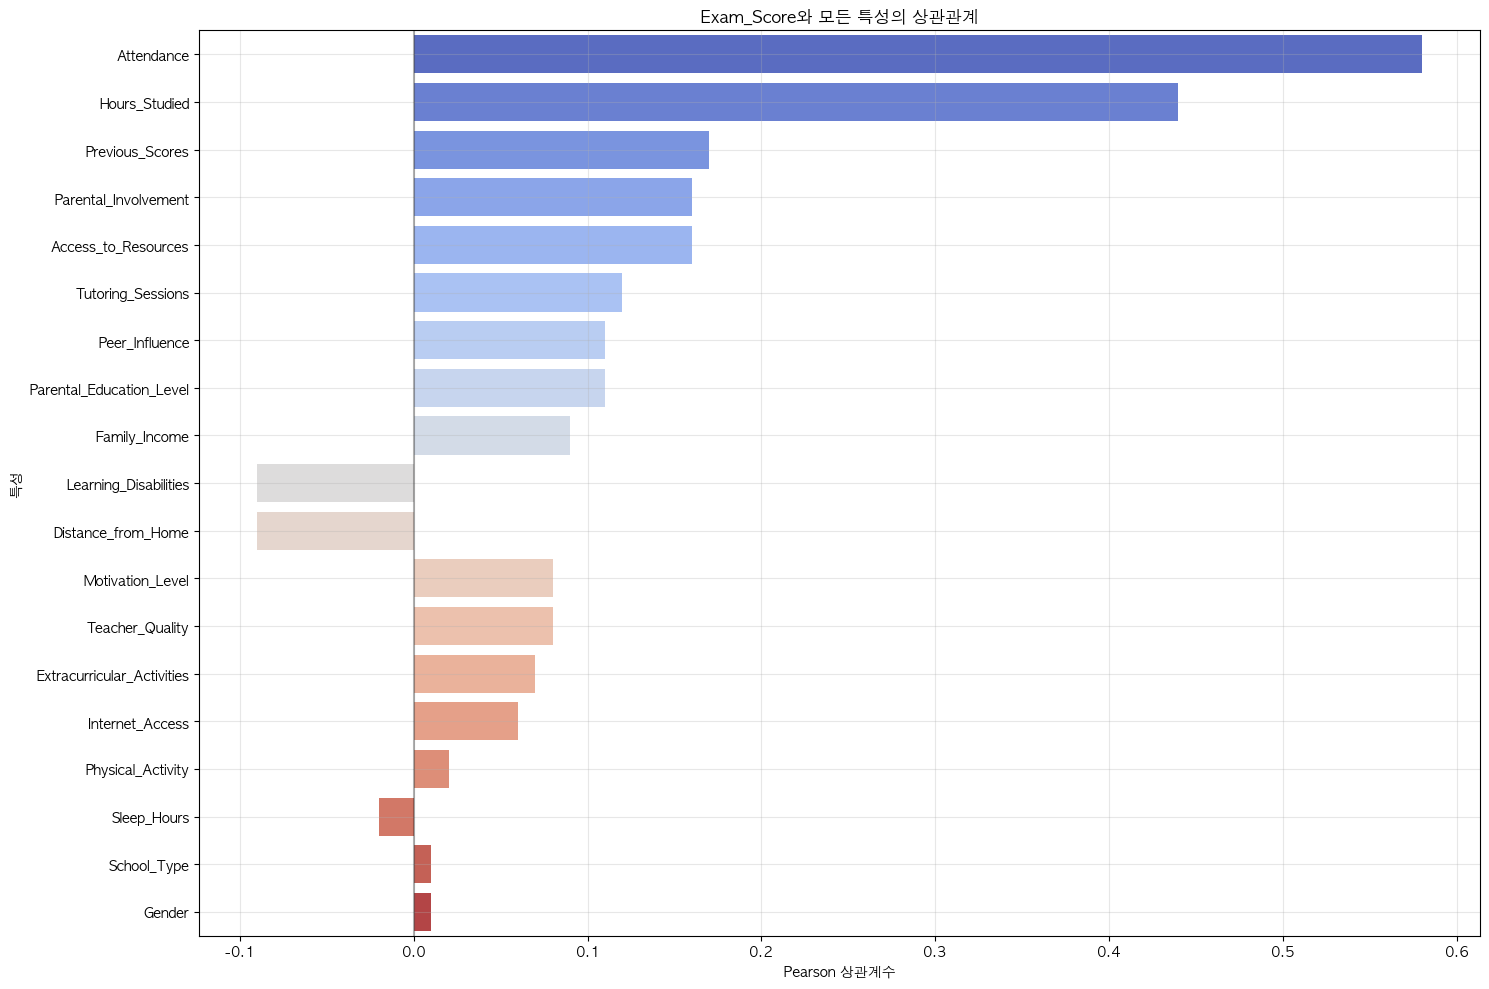

In [4]:
# 4. Exam_Score와 상관관계 분석 (Pearson 상관계수 사용)
print("=== Exam_Score와 상관관계 분석 (Pearson) ===")

# 모든 수치형 변수로 상관관계 계산 (수치형 + 인코딩된 범주형 변수 - 타겟 변수) 
print(f"분석 대상 변수 수: {len(df.columns)-1}개 (타겟 변수 제외)")

# Pearson 상관계수 계산 알고리즘
correlation_matrix = df.corr().round(2)   
target_corr = correlation_matrix['Exam_Score'].drop('Exam_Score').sort_values() # 오름차순으로 정렬

# 절댓값 기준으로 정렬
target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index) # 절대값 변환 후 정렬

# 막대그래프 시각화
plt.figure(figsize=(15, 10))
sns.barplot(x=target_corr_sorted.values, y=target_corr_sorted.index, palette="coolwarm")
plt.title("Exam_Score와 모든 특성의 상관관계")
plt.xlabel("Pearson 상관계수")
plt.ylabel("특성")
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

# 5. 피처 기반으로 기존 데이터프레임으로부터 추출:  입력 변수 : X, 출력변수: y 정의
X = df.drop('Exam_Score', axis=1)
y = df['Exam_Score']

print(f"=== 데이터 분리 완료 ===")
print(f"X.shape: {X.shape}") # (5915, 19)
print(f"y.shape: {y.shape}") # (5915, )

# 6. 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. 데이터 정제: 훈련 데이터로 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # 훈련 데이터로만 스케일러 학습하고 변환
X_test_scaled = scaler.transform(X_test) # 테스트 데이터는 훈련 데이터의 파라미터로 변환만

# 8. 모델(가설)  정의 및 학습:  Linear, RidgeCV, LassoCV,  Polynomial

# 8-1. 다중 선형 회귀 설정 (기본 모델, 베이스라인 모델)
linear = LinearRegression().fit(X_train_scaled, y_train) # 다중 선형 회귀 모델
score_linear = r2_score(y_test, linear.predict(X_test_scaled))

# 8-2. 규제항을 갖는 선형 회귀 모델 설정: RidgeCV(), LassoCV()
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5).fit(X_train_scaled, y_train)
score_ridge = r2_score(y_test, ridge.predict(X_test_scaled))

lasso = LassoCV(cv=5, max_iter=10000).fit(X_train_scaled, y_train)
score_lasso = r2_score(y_test, lasso.predict(X_test_scaled))

# 8-3. 고차원 (2차 함수) 추가: 과적합 방지 - (Polynomial + Linear Regression, Polynomial + RidgeCV)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
poly_model = LinearRegression().fit(X_train_poly, y_train)
score_poly = r2_score(y_test, poly_model.predict(X_test_poly))

poly_ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5).fit(X_train_poly, y_train)
score_poly_ridge = r2_score(y_test, poly_ridge.predict(X_test_poly))

# 모델 결과 출력 시
print("\n모델 별 결정계수(R²)")
print(f"Linear Regression - 결정계수(R²): {score_linear:.4f}")
print(f"RidgeCV - 결정계수(R²): {score_ridge:.4f}")
print(f"LassoCV - 결정계수(R²): {score_lasso:.4f}")
print(f"Polynomial - 결정계수(R²): {score_poly:.4f}")
print(f"Polynomial + RidgeCV - 결정계수(R²): {score_poly_ridge:.4f}")

print("모든 모델 학습 완료")


=== 데이터 분리 완료 ===
X.shape: (5915, 19)
y.shape: (5915,)

모델 별 결정계수(R²)
Linear Regression - 결정계수(R²): 0.6404
RidgeCV - 결정계수(R²): 0.6405
LassoCV - 결정계수(R²): 0.6405
Polynomial - 결정계수(R²): 0.6231
Polynomial + RidgeCV - 결정계수(R²): 0.6241
모든 모델 학습 완료


=== 모델 성능 순위 ===
                   Model  R²_Score
2             LassoCV R²    0.6405
1             RidgeCV R²    0.6405
0              Linear R²    0.6404
4        Poly+RidgeCV R²    0.6241
3  Polynomial R² (deg=2)    0.6231


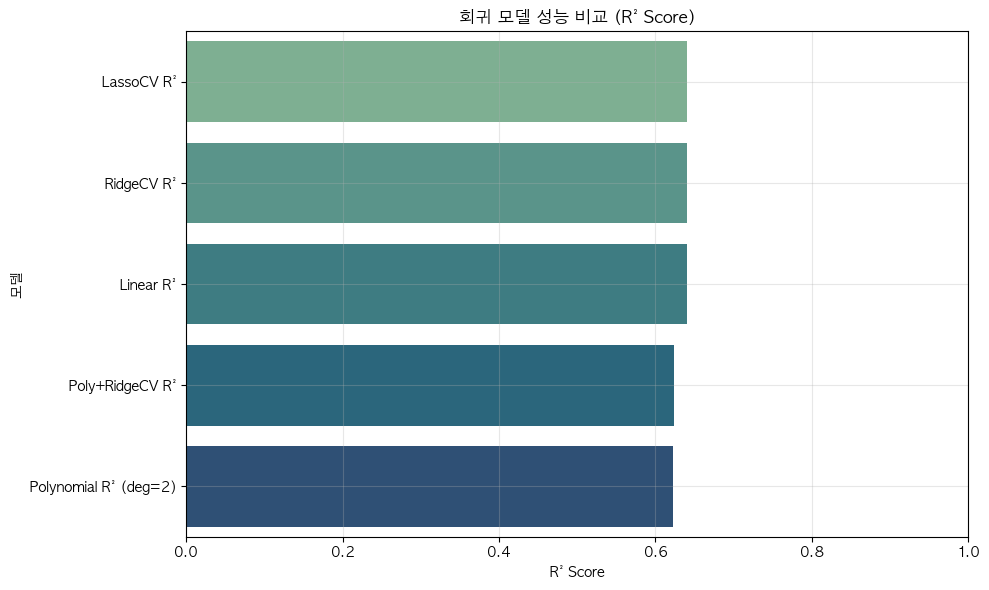

In [6]:
# 9. 회귀 성능 비교 
# dictionary로 모델명과 R^2 점수로 저장
r2_results = {
    "Linear R²": r2_score(y_test, linear.predict(X_test_scaled)),
    "RidgeCV R²": r2_score(y_test, ridge.predict(X_test_scaled)),
    "LassoCV R²": r2_score(y_test, lasso.predict(X_test_scaled)),
    "Polynomial R² (deg=2)": r2_score(y_test, poly_model.predict(X_test_poly)),
    "Poly+RidgeCV R²": r2_score(y_test, poly_ridge.predict(X_test_poly))
}

# 성능 테이블
r2_df = pd.DataFrame({
    'Model': list(r2_results.keys()),
    'R²_Score': list(r2_results.values())
}).sort_values(by='R²_Score', ascending=False)  

print("=== 모델 성능 순위 ===")
print(r2_df.round(4))

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='R²_Score', y='Model', data=r2_df, palette='crest', hue='Model')
plt.title("회귀 모델 성능 비교 (R² Score)")
plt.xlabel("R² Score")
plt.ylabel("모델")
plt.xlim(0, 1.0)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

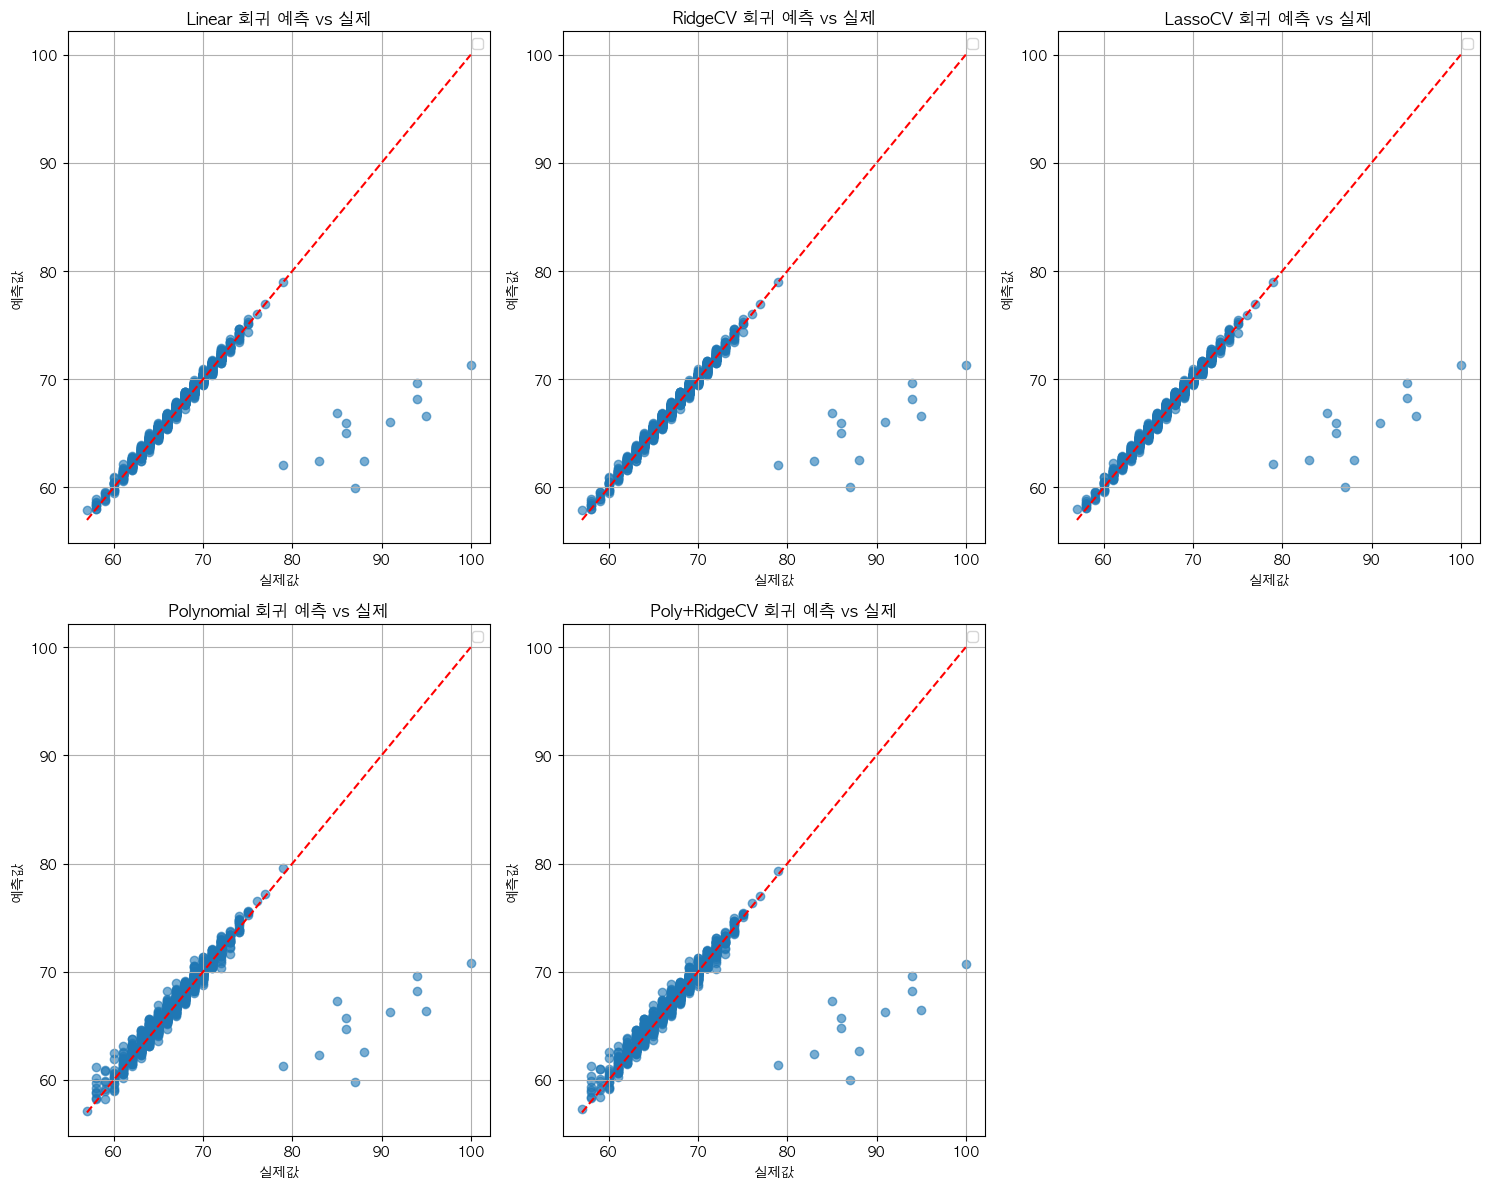


=== 상세 성능 지표 ===
Linear          - R²: 0.6404, MSE: 5.8554, MAE: 0.5436, RMSE: 2.4198
RidgeCV         - R²: 0.6405, MSE: 5.8544, MAE: 0.5437, RMSE: 2.4196
LassoCV         - R²: 0.6405, MSE: 5.8532, MAE: 0.5449, RMSE: 2.4193
Polynomial      - R²: 0.6231, MSE: 6.1377, MAE: 0.6997, RMSE: 2.4774
Poly+RidgeCV    - R²: 0.6241, MSE: 6.1216, MAE: 0.6950, RMSE: 2.4742


In [7]:

# 10. 모델별 예측 vs 실제 산점도(산포도)

models = {
    'Linear': linear.predict(X_test_scaled),
    'RidgeCV': ridge.predict(X_test_scaled),
    'LassoCV': lasso.predict(X_test_scaled),
    'Polynomial': poly_model.predict(X_test_poly),
    'Poly+RidgeCV': poly_ridge.predict(X_test_poly)
}


plt.figure(figsize=(15, 12))
for i, (name, y_pred) in enumerate(models.items(), 1):  # 파이썬에서 반복문을 돌릴 때 인덱스 번호와 값을 동시에 가져오는 함수
    plt.subplot(2, 3, i)
    
    # 산점도
    plt.scatter(y_test, y_pred, alpha=0.6)
    # 완벽한 예측선 (y=x)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name} 회귀 예측 vs 실제")
    plt.xlabel("실제값")
    plt.ylabel("예측값")
    plt.grid(True)
    plt.legend()
plt.tight_layout()
plt.show()

# 성능 지표 상세 분석
print("\n=== 상세 성능 지표 ===")
detailed_metrics = {}
r2_scores = {}  # R² 점수를 저장할 딕셔너리

for name, y_pred in models.items():
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    detailed_metrics[name] = {
        'R²': r2,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse
    }
    r2_scores[name] = r2  # R² 점수 저장

    print(f"{name:15} - R²: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    

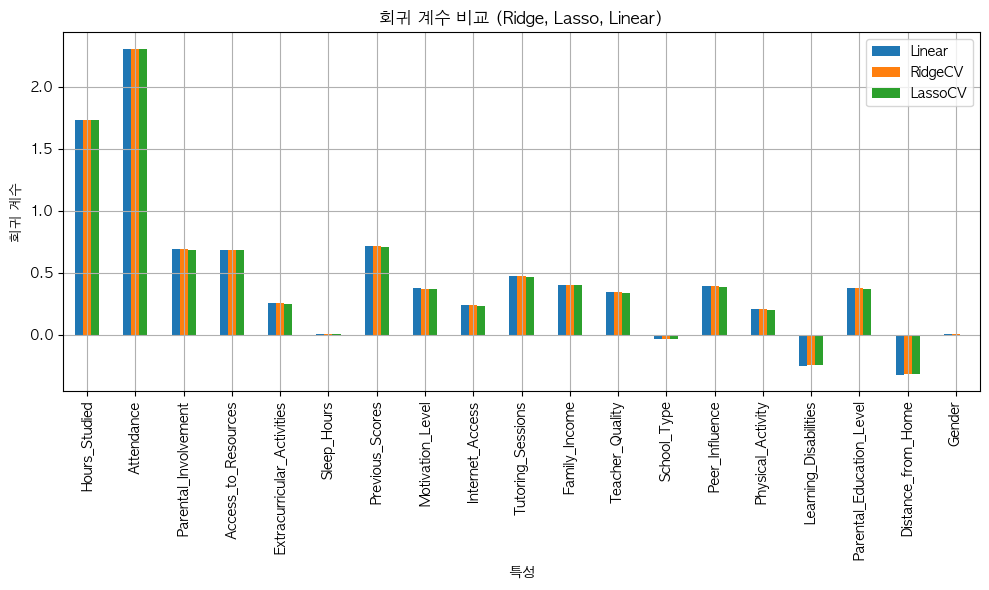

In [8]:
# 11. 회귀 계수 비교 표 및 시각화 (Ridge, Lasso, Linear) - Polynomial은 특성의 개수가 다르기에 제외
coef_df = pd.DataFrame({
    'Linear': linear.coef_,
    'RidgeCV': ridge.coef_,
    'LassoCV': lasso.coef_
}, index=X.columns)

coef_df.plot(kind='bar', figsize=(10, 6)) # 추출한 컬럼을 기준으로 각 모델 계수의 크기와 방향을 막대 그래프로 시각화
plt.title("회귀 계수 비교 (Ridge, Lasso, Linear)")
plt.xlabel("특성")
plt.ylabel("회귀 계수")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:

# 12. 모델 및 스케일러 저장 

# 각 모델을 개별 파일로 저장
joblib.dump(linear, 'linear_model.pkl')
joblib.dump(ridge, 'ridge_model.pkl')
joblib.dump(lasso, 'lasso_model.pkl')
joblib.dump(poly_model, 'polynomial_model.pkl')
joblib.dump(poly_ridge, 'poly_ridge_model.pkl')

# 12-1. 스케일러 저장
joblib.dump(scaler, 'scaler.pkl')

# 12-2. Polynomial Features 저장
joblib.dump(poly, 'poly_features.pkl')
joblib.dump(X.columns, "features.pkl")

# 12-3 # R² 점수를 저장
joblib.dump(r2_scores, "r2_scores.pkl")

print("모델, 스케일러, 특성, R2 점수 저장 완료!")

모델, 스케일러, 특성, R2 점수 저장 완료!
